<a href="https://colab.research.google.com/github/paulsoulard/Mapbox/blob/main/02_velov_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![lyon2 geonum](https://perso.liris.cnrs.fr/lmoncla/GEONUM/fig/logos.png)

# 2A3 – Modélisation et structuration de données géographiques et applications SGBD spatiaux


## Tutoriel : Analyse des données des disponibilités des stations Vélo'v de la Métropole de Lyon


# Partie 2 : Analyse et visualisation des données


Dans le cadre de ce TP,  vous avez à votre disposition l'ensemble des données pour l'année 2021.


Les objectifs de cette partie sont les suivants : 

* Analyser les données : requêter le jeu de données pour générer des graphiques, des cartes et des cartes animées.



## 1. Importation des libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone

import folium
import plotly
import plotly.express as px
import geopandas

In [4]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 34.4 MB/s 
     |████████████████████████████████| 6.3 MB 50.0 MB/s 


## 2. Récupération du jeu de données

Dans un premier temps il faut récupérer les données. D'un côté le jeu de données contenant les localisations des stations et de l'autre l'historique d'utilisation. Le second a été modifié lors de la précédente séance. Pour ne pas avoir à refaire tous les traitements vous pouvez récupérer directement l'archive `data-bikes-2.zip`.

L'ensemble des données utilisées dans ce tutoriel est disponible à cette adresse : 
https://perso.liris.cnrs.fr/lmoncla/GEONUM/

* Télécharger les archives contenant les données
1. data-stations.zip
2. data-bikes-2.zip

Ces 2 archives contiennent chacune un fichier CSV contenant respectivement la liste des stations vélov (et leur localisation) et la liste des disponibilités de chaque station par tranche de 30 minutes.


In [5]:
## On commence par créer un dossier dans lequel on va télécharger les données
## Peut être fait directement depuis l'explorateur de fichiers
!mkdir data

In [6]:
## on se déplace dans le nouveau dossier
%cd data

/content/data


In [7]:
## On télécharge l'archive contenant la liste des stations
!wget https://perso.liris.cnrs.fr/lmoncla/GEONUM/data-stations.zip
    
## On télécharge l'archive contenant la liste des disponibilité des stations par tranche de 5 minutes
!wget https://perso.liris.cnrs.fr/lmoncla/GEONUM/data-bikes-2.zip

--2022-02-08 07:42:22--  https://perso.liris.cnrs.fr/lmoncla/GEONUM/data-stations.zip
Resolving perso.liris.cnrs.fr (perso.liris.cnrs.fr)... 134.214.142.28
Connecting to perso.liris.cnrs.fr (perso.liris.cnrs.fr)|134.214.142.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588 (3.5K) [application/zip]
Saving to: ‘data-stations.zip’

data-stations.zip   100%[===================>]   3.50K  --.-KB/s    in 0s      

2022-02-08 07:42:23 (198 MB/s) - ‘data-stations.zip’ saved [3588/3588]

--2022-02-08 07:42:23--  https://perso.liris.cnrs.fr/lmoncla/GEONUM/data-bikes-2.zip
Resolving perso.liris.cnrs.fr (perso.liris.cnrs.fr)... 134.214.142.28
Connecting to perso.liris.cnrs.fr (perso.liris.cnrs.fr)|134.214.142.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44004221 (42M) [application/zip]
Saving to: ‘data-bikes-2.zip’

data-bikes-2.zip    100%[===================>]  41.96M  19.5MB/s    in 2.2s    

2022-02-08 07:42:25 (19.5 MB/s) - ‘data

### 2.1. Chargement des données

Comme la dernière fois, pour charger les données il suffit d'utiliser la méthode [read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html#pandas.read_csv) de la librairie `Pandas`. Elle prend en paramètre le chemin du fichier que l'on souhaite charger. Ce fichier peut être de 2 formats, soit directement un fichier CSV, soit un fichier ZIP contenant un CSV. Dans notre, cas il est donc inutile de dézipper les archives téléchargées précédemment.


In [8]:
## On charge les données des stations dans un dataframe
df_stations = pd.read_csv('data-stations.zip')

## On crée maintenant le dataframe avec les données d'historique
df_bikes = pd.read_csv('data-bikes-2.zip')

In [9]:
## On affiche les premières lignes
df_stations.head()

,id_velov,latitude,longitude
0,velov-10056,45.779112,4.871952
1,velov-9013,45.787384,4.814374
2,velov-5044,45.759797,4.796627
3,velov-9014,45.783341,4.811433
4,velov-10058,45.767126,4.892150


In [10]:
## On affiche les premières lignes
df_bikes.head()

,id_velov,year,month,day,hour,minute,time,bikes,bike_stands,departure30min,arrival30min,daily_departure,daily_arrival,IsWeekday
0,velov-10001,2021,1,1,0,0,2021-01-01 00:00:00+00:00,8,22,0,0,7.0,6.0,True
1,velov-10001,2021,1,1,0,30,2021-01-01 00:30:00+00:00,8,22,0,0,7.0,6.0,True
2,velov-10001,2021,1,1,1,0,2021-01-01 01:00:00+00:00,7,23,1,0,7.0,6.0,True
3,velov-10001,2021,1,1,1,30,2021-01-01 01:30:00+00:00,7,23,0,0,7.0,6.0,True
4,velov-10001,2021,1,1,2,0,2021-01-01 02:00:00+00:00,7,23,0,0,7.0,6.0,True


### 2.2. Premier apercu des données d'historique

In [11]:
## On affiche les information sur les données
df_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800252 entries, 0 to 7800251
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id_velov         object 
 1   year             int64  
 2   month            int64  
 3   day              int64  
 4   hour             int64  
 5   minute           int64  
 6   time             object 
 7   bikes            int64  
 8   bike_stands      int64  
 9   departure30min   int64  
 10  arrival30min     int64  
 11  daily_departure  float64
 12  daily_arrival    float64
 13  IsWeekday        bool   
dtypes: bool(1), float64(2), int64(9), object(2)
memory usage: 781.1+ MB


In [12]:
# Réduction de la taille en mémoire

## on transforme le type des colonnes en entier ou float lorsque cela est nécessaire
df_bikes[['year', 'daily_departure', 'daily_arrival']] = df_bikes[['year', 'daily_departure', 'daily_arrival']].astype('int16')
df_bikes[['month','day','hour','minute', 'bikes', 'bike_stands', 'departure30min','arrival30min']] = df_bikes[['month','day','hour','minute', 'bikes', 'bike_stands', 'departure30min','arrival30min']].astype('int8')


In [13]:
## On affiche les information sur les données
df_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800252 entries, 0 to 7800251
Data columns (total 14 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id_velov         object
 1   year             int16 
 2   month            int8  
 3   day              int8  
 4   hour             int8  
 5   minute           int8  
 6   time             object
 7   bikes            int8  
 8   bike_stands      int8  
 9   departure30min   int8  
 10  arrival30min     int8  
 11  daily_departure  int16 
 12  daily_arrival    int16 
 13  IsWeekday        bool  
dtypes: bool(1), int16(3), int8(8), object(2)
memory usage: 230.6+ MB


## 3. Interrogation et visualisation des données

Lors de la précédente séance, nous avons vu comment préparer et manipuler les données. Nous pouvons maintenant se concentrer sur l'interrogation et la visualisation des données.

In [14]:
## On commence par faire une copie de notre DataFrame, pour pouvoir revenir aux données initiales si besoin
df_sampled = df_bikes.copy()

### 3.1 Graphiques (dimension temporelle)

Dans le but d'obtenir une première répartition des données, on souhaite afficher sur un graphique la somme cumulée des départs (ou arrivées) en fonction des heures de la journée (par tranche de 30 minutes).

#### 3.1.1 Affichage des départs et arrivées (somme cumulée)

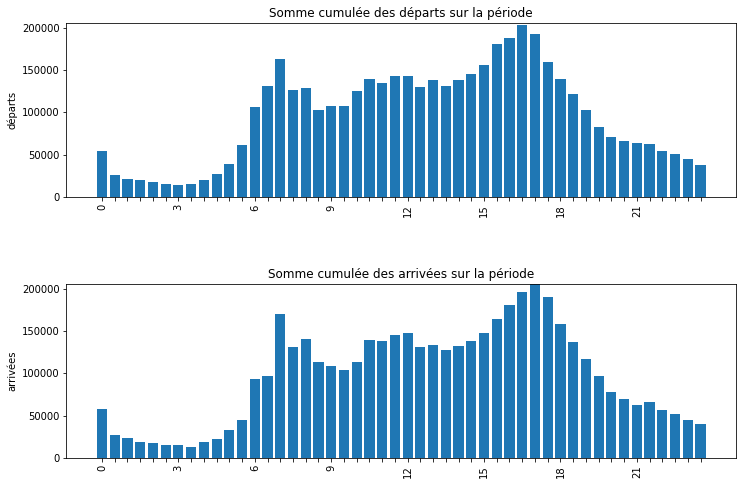

In [15]:
## On groupe les lignes du dataframe selon les colonnes 'hour' et 'minute'
## et on somme les valeurs de la colonne 'departure30min'
values_departure = df_sampled.groupby(['hour', 'minute'])['departure30min'].sum().values
values_arrival = df_sampled.groupby(['hour', 'minute'])['arrival30min'].sum().values

## On récupère la valeur max pour limiter l'axe des ordonnées
y_max = max(max(values_departure), max(values_arrival))

## On fixe les valeurs visibles de l'axe des abcisses
## Les valeurs par défauts ne sont pas adaptées dans notre cas
x_labels = [0,'','','','','',3,'','','','','',6,'','','','','',9,'','','','','',12,'','','','','',15,'','','','','',18,'','','','','',21,'','','','','']

## On crée la figure qui contiendra les 2 graphiques (départs et arrivées) (on utilise la librairie matplotlib)
fig = plt.figure(figsize=(12, 8))
## On utilise la méthode subplot pour créer les 2 graphiques. 
## Subplot() prend 3 paramètres : nombre de lignes, de colonne, et numéro du plot
plt.subplot(2,1,1)
plt.bar(range(len(values_departure)), values_departure)
plt.ylabel('départs')
plt.xticks(range(len(values_departure)), x_labels, rotation='vertical')
plt.ylim([0, y_max])
plt.title('Somme cumulée des départs sur la période')

## On crée le deuxième graphique
plt.subplot(2,1,2)
plt.bar(range(len(values_arrival)), values_arrival)
plt.ylabel('arrivées')
plt.xticks(range(len(values_arrival)), x_labels, rotation='vertical')
plt.ylim([0, y_max])
plt.title('Somme cumulée des arrivées sur la période')

## On ajoute un espace entre les deux graphiques
plt.subplots_adjust(hspace=0.5)

## On affiche les graphiques
plt.show()

#### 3.1.2 Comparaison jours de semaine et weekend

En reprenant le code précédent, proposez une solution permettant de comparer les jours de semaine et de weekend.


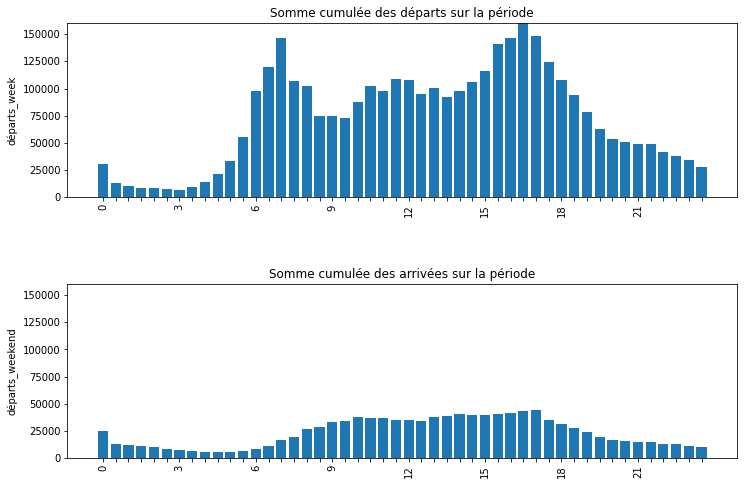

In [16]:
#**** A COMPLETER
#**** A COMPLETER
## On groupe les lignes du dataframe selon les colonnes 'hour' et 'minute'
## et on somme les valeurs de la colonne 'departure30min'
values_departure_week = df_sampled.loc[df_sampled['IsWeekday']== True,:].groupby(['hour', 'minute'])['departure30min'].sum().values
values_departure_weekend = df_sampled.loc[df_sampled['IsWeekday']== False,:].groupby(['hour', 'minute'])['departure30min'].sum().values


## On récupère la valeur max pour limiter l'axe des ordonnées
y_max = max(max(values_departure_week), max(values_departure_weekend))

## On fixe les valeurs visibles de l'axe des abcisses
## Les valeurs par défauts ne sont pas adaptées dans notre cas
x_labels = [0,'','','','','',3,'','','','','',6,'','','','','',9,'','','','','',12,'','','','','',15,'','','','','',18,'','','','','',21,'','','','','']

## On crée la figure qui contiendra les 2 graphiques (départs et arrivées) (on utilise la librairie matplotlib)
fig = plt.figure(figsize=(12, 8))
## On utilise la méthode subplot pour créer les 2 graphiques. 
## Subplot() prend 3 paramètres : nombre de lignes, de colonne, et numéro du plot
plt.subplot(2,1,1)
plt.bar(range(len(values_departure_week)), values_departure_week)
plt.ylabel('départs_week')
plt.xticks(range(len(values_departure_week)), x_labels, rotation='vertical')
plt.ylim([0, y_max])
plt.title('Somme cumulée des départs sur la période')

## On crée le deuxième graphique
plt.subplot(2,1,2)
plt.bar(range(len(values_departure_weekend)), values_departure_weekend)
plt.ylabel('départs_weekend')
plt.xticks(range(len(values_departure_weekend)), x_labels, rotation='vertical')
plt.ylim([0, y_max])
plt.title('Somme cumulée des arrivées sur la période')

## On ajoute un espace entre les deux graphiques
plt.subplots_adjust(hspace=0.5)

## On affiche les graphiques
plt.show()







#### 3.1.3 Comparaison semaines vacances scolaire, hors vacances, confinement, été, etc...

On souhaite maintenant faire une comparaison entre une semaine d'octobre (avant le 2ème confinement) une semaine de novembre (pendant le 2ème confinement) et une semaine en décembre ou janvier avec un couvre-feu à 18h. L'objectif est d'analyser si ces contraintes ont eu un effet sur la fréquentation des stations Vélo'v.

semaine du 15 au 21 février : vacances scolaires
semaine du 4 au 11 avril : couvre-feu + télétravail
semaine du 2 au 8 août : été


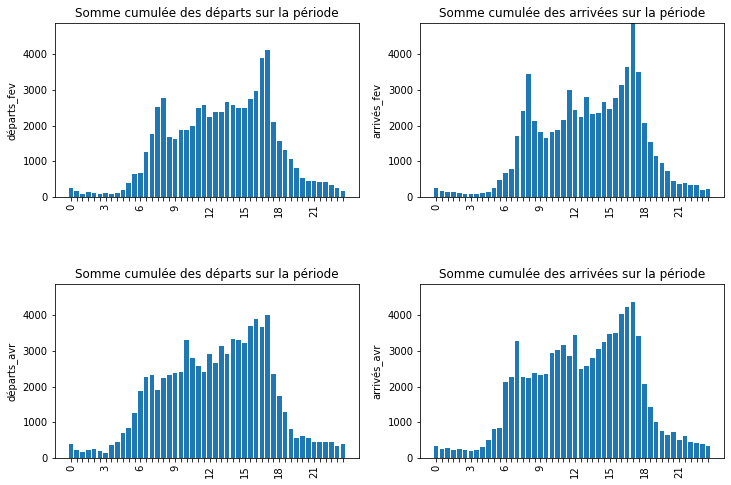

In [20]:
#**** A COMPLETER
#**** A COMPLETER
## On groupe les lignes du dataframe selon les colonnes 'hour' et 'minute'
## et on somme les valeurs de la colonne 'departure30min'
values_week_fev = df_sampled.loc[(df_sampled.month == 2) & ((df_sampled.day >= 15) & (df_sampled.day <= 21)),:]
values_week_avr = df_sampled.loc[(df_sampled.month == 4) & ((df_sampled.day >= 4) & (df_sampled.day <= 11)),:]
values_week_aou = df_sampled.loc[(df_sampled.month == 8) & ((df_sampled.day >= 2) & (df_sampled.day <= 8)),:]

values_week_departure_fev = values_week_fev.groupby(['hour', 'minute'])['departure30min'].sum().values
values_week_arrival_fev =values_week_fev.groupby(['hour', 'minute'])['arrival30min'].sum().values

values_week_departure_avr = values_week_avr.groupby(['hour', 'minute'])['departure30min'].sum().values
values_week_arrival_avr =values_week_avr.groupby(['hour', 'minute'])['arrival30min'].sum().values


## On récupère la valeur max pour limiter l'axe des ordonnées
y_max = max(max(values_week_departure_fev), max(values_week_arrival_fev), max(values_week_departure_avr), max(values_week_arrival_avr))

## On fixe les valeurs visibles de l'axe des abcisses
## Les valeurs par défauts ne sont pas adaptées dans notre cas
x_labels = [0,'','','','','',3,'','','','','',6,'','','','','',9,'','','','','',12,'','','','','',15,'','','','','',18,'','','','','',21,'','','','','']

## On crée la figure qui contiendra les 2 graphiques (départs et arrivées) (on utilise la librairie matplotlib)
fig = plt.figure(figsize=(12, 8))
## On utilise la méthode subplot pour créer les 2 graphiques. 
## Subplot() prend 3 paramètres : nombre de lignes, de colonne, et numéro du plot
plt.subplot(2,2,1)
plt.bar(range(len(values_week_departure_fev)), values_week_departure_fev)
plt.ylabel('départs_fev')
plt.xticks(range(len(values_week_departure_fev)), x_labels, rotation='vertical')
plt.ylim([0, y_max])
plt.title('Somme cumulée des départs sur la période')

## On crée le deuxième graphique
plt.subplot(2,2,2)
plt.bar(range(len(values_week_arrival_fev)), values_week_arrival_fev)
plt.ylabel('arrivés_fev')
plt.xticks(range(len(values_week_arrival_fev)), x_labels, rotation='vertical')
plt.ylim([0, y_max])
plt.title('Somme cumulée des arrivées sur la période')

## On utilise la méthode subplot pour créer les 2 graphiques. 
## Subplot() prend 3 paramètres : nombre de lignes, de colonne, et numéro du plot
plt.subplot(2,2,3)
plt.bar(range(len(values_week_departure_avr)), values_week_departure_avr)
plt.ylabel('départs_avr')
plt.xticks(range(len(values_week_departure_avr)), x_labels, rotation='vertical')
plt.ylim([0, y_max])
plt.title('Somme cumulée des départs sur la période')

## On crée le deuxième graphique
plt.subplot(2,2,4)
plt.bar(range(len(values_week_arrival_avr)), values_week_arrival_avr)
plt.ylabel('arrivés_avr')
plt.xticks(range(len(values_week_arrival_avr)), x_labels, rotation='vertical')
plt.ylim([0, y_max])
plt.title('Somme cumulée des arrivées sur la période')

## On ajoute un espace entre les deux graphiques
plt.subplots_adjust(hspace=0.5)

## On affiche les graphiques
plt.show()







Beaucoup d'autres analyses sont possibles comme par exemple, étudier l'impact de la météo (pluie, neige, température), d'une grève des transports, des vacances scolaires, des fêtes ou soirées de réveillon, etc.

ex : neige 17 janvier 2021

In [ ]:
#**** A COMPLETER





#### 3.1.4 Départs cumulés par jour sur un mois

In [ ]:
#**** A COMPLETER





### 3.2 Cartes (dimension spatiale)

Pour l'analyse de données géographiques il sera intéressant de les afficher sous forme de carte afin de pouvoir visualiser leur répartition et permettre une meilleure interprétation.

Il existe plusieurs types de cartes que l'on peut générer en fonction du type d'information que l'on souhaite afficher.

#### 3.2.1 Heatmap ou carte de fréquentation

Dans un premier temps on se propose de créer une carte de fréquentation (ou heatmap) représentant la densité de répartition des stations vélo'v.

In [21]:
df_stations[['latitude', 'longitude']].values

array([[45.779112,  4.871952],
       [45.787384,  4.814374],
       [45.759797,  4.796627],
       [45.783341,  4.811433],
       [45.767126,  4.89215 ],
       [45.778554,  4.80704 ],
       [45.758788,  4.878976],
       [45.739608,  4.815074],
       [45.761788,  4.886157],
       [45.75947 ,  4.830145],
       [45.77332 ,  4.85183 ],
       [45.765949,  4.831107],
       [45.766855,  4.858974],
       [45.770134,  4.805158],
       [45.763376,  4.82904 ],
       [45.768412,  4.859071],
       [45.771006,  4.807613],
       [45.779702,  4.859991],
       [45.75308 ,  4.829649],
       [45.766806,  4.832934],
       [45.782306,  4.849344],
       [45.742646,  4.820494],
       [45.78219 ,  4.87688 ],
       [45.770784,  4.872959],
       [45.768876,  4.884242],
       [45.771558,  4.89037 ],
       [45.750481,  4.788774],
       [45.767044,  4.826984],
       [45.76375 ,  4.843743],
       [45.757963,  4.834636],
       [45.757565,  4.800962],
       [45.749253,  4.829844],
       [

In [22]:
from folium.plugins import HeatMap

# On initialise la carte avec la librairie Folium (centrée sur Lyon)
Lyon = [45.76, 4.85]
m = folium.Map(location=Lyon, zoom_start = 13) 

# On récupère la liste des coordonnées lat/lon des stations
heat_data = df_stations[['latitude', 'longitude']].values

# On appelle la fonction HeatMap de la librairie folium à partir de la liste des coordonnées et on l'ajoute à la carte
HeatMap(heat_data).add_to(m)

# On affiche la carte
m

Maintenant on souhaite créer une carte qui aurait plus de sens que simplement afficher la densité des localisations de stations. EN particulier, on souhaite afficher les densités localisées de départs en fonction des quartiers.

 

#### 3.2.2 Afficher des géométries

On souhaite maintenant pouvoir distinguer les différents quartiers de la métropole et obtenir un résultat comme sur l'image ci-dessous.

![quartiers du grand lyon](https://perso.liris.cnrs.fr/lmoncla/GEONUM/fig/quartiers_lyon.png)

Pour cela on va récupérer la géométries des différents quartiers de la métropole et les afficher sur la carte.
On va expérimenter 2 méthodes d'affichage selon le format des géométries (GeoJSON vs Shapefile) : 
1. format GeoJSON affiché avec la libraie Folium
2. format GeoJSON affiché avec GeoPandas et Plotly
3. format Shapefile affiché avec GeoPandas et Plotly

On télécharge les géométries (dans les 2 formats) des différents quartiers de la métropole (
https://www.data.gouv.fr/fr/datasets/quartiers-des-communes-de-la-metropole-de-lyon/)




In [23]:
## On télécharge les données 
!wget https://perso.liris.cnrs.fr/lmoncla/GEONUM/data-geom-quartiers-lyon.zip

--2022-02-08 08:26:05--  https://perso.liris.cnrs.fr/lmoncla/GEONUM/data-geom-quartiers-lyon.zip
Resolving perso.liris.cnrs.fr (perso.liris.cnrs.fr)... 134.214.142.28
Connecting to perso.liris.cnrs.fr (perso.liris.cnrs.fr)|134.214.142.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 648545 (633K) [application/zip]
Saving to: ‘data-geom-quartiers-lyon.zip’

data-geom-quartiers 100%[===================>] 633.34K  1.22MB/s    in 0.5s    

2022-02-08 08:26:07 (1.22 MB/s) - ‘data-geom-quartiers-lyon.zip’ saved [648545/648545]



In [24]:
import zipfile

## dézipper l'archive (utilise la librairie zipfile)
with zipfile.ZipFile("data-geom-quartiers-lyon.zip","r") as zip_ref:
    zip_ref.extractall("./")


Cette archive contient 5 fichiers : 
1. adr_voie_lieu.adrquartier.dbf
2. adr_voie_lieu.adrquartier.json
3. adr_voie_lieu.adrquartier.prj
4. adr_voie_lieu.adrquartier.shp
5. adr_voie_lieu.adrquartier.shx


Onn s'intéresse en particulier aux fichiers `.json` et `.shp`.

##### Format GeoJSON affiché avec la libraie Folium

 - Aidez-vous de la [documentation](https://python-visualization.github.io/folium/quickstart.html#GeoJSON/TopoJSON-Overlays) pour ajouter une couche geojson à votre carte.

In [25]:
## On initialise le chemin vers le fichier geojson
jsonfile = "./data-geom-quartiers-lyon/adr_voie_lieu.adrquartier.json"

## On initialise la carte avec Folium
m = folium.Map(location = Lyon, zoom_start = 12, tiles = "CartoDB positron")

## On ajoute la couche geojson à partir de notre fichier qui contient les géométries des quartiers
folium.GeoJson(jsonfile, name="geojson").add_to(m)

## On ajoute la couche de controle pour les interaction avec la carte
folium.LayerControl().add_to(m)

## On affiche la carte
m

##### Format GeoJSON affiché avec GeoPandas et Plotly

In [26]:
## On initialise le chemin vers le fichier geojson
jsonfile = "./data-geom-quartiers-lyon/adr_voie_lieu.adrquartier.json"

## On charge le fichier GeoJSON qui contient les géométries dans un geodataframe
gdf_districts_json = geopandas.read_file(jsonfile)

## On affiche les premières lignes
gdf_districts_json.head()

NameError: ignored

In [ ]:
## On initialise une carte avec la méthode choropleth_mapbox() de la librairie Plotly Express.
## Se référer à la doc pour la description des paramètres
## https://plotly.github.io/plotly.py-docs/generated/plotly.express.choropleth_mapbox.html

fig = px.choropleth_mapbox(gdf_districts_json, 
                           geojson=gdf_districts_json, 
                           locations=gdf_districts_json.index, 
                           mapbox_style="carto-positron",
                           zoom=12, center = {"lat": Lyon[0], "lon": Lyon[1]},
                           opacity=0.5
                          )

## On supprime les marges
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

## On affiche la carte
fig.show()


##### Format Shapefile affiché avec GeoPandas et Plotly

La librairie [GeoPandas](https://geopandas.org/io.html) peut charger la plupart des formats de données spatiales grâce à la méthode `read_file()`

In [ ]:
## On initialise le chemin vers le fichier shape
shpfile = "./data-geom-quartiers-lyon/adr_voie_lieu.adrquartier.shp"

## On charge directement les données du shapefile dans un geodataframe
gdf_districts_shp = geopandas.read_file(shpfile)
   
## On affiche les premières lignes
gdf_districts_shp.head()

In [ ]:
## On compare avec le geodataframe chargé à partir du JSON
gdf_districts_json.head()

In [ ]:
## Une fois les données dans le geodataframe on peut réutiliser directement le même code pour l'affichage

## On initialise une carte avec la méthode choropleth_mapbox() de la librairie Plotly Express.
## Se référer à la doc pour la description des paramètres
## https://plotly.github.io/plotly.py-docs/generated/plotly.express.choropleth_mapbox.html

fig = px.choropleth_mapbox(gdf_districts_shp, 
                           geojson=gdf_districts_shp, 
                           locations=gdf_districts_shp.index, 
                           mapbox_style="carto-positron",
                           zoom=12, center = {"lat": Lyon[0], "lon": Lyon[1]},
                           opacity=0.5
                          )

## On supprime les marges
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

## On affiche la carte
fig.show()

#### 3.2.3 Carte thématique colorée (carte choroplèthe)

Maintenant qu'on a récupéré et affiché les quartiers on souhaite ajouter des informations associées à ces quartiers. Pour commencer, on souhaite générer une carte où la couleur de chaque polygone dépend du nombre de stations présentes dans la zone.

Pour cela, nous devons affecter à chaque station l'identifiant de la zone à laquelle elle appartient.

On utilise la méthode contains() de la librairie GeoPandas https://geopandas.org/reference.html#geopandas.GeoSeries.contains afin d'associer l'id de la zone corresponte à chaque station.

In [ ]:
## On importe la fontion Point() de la librairie Shapely 
## qui permet de créer une variable de type Point à partir des coordonnées lat/lng
from shapely.geometry import Point

## On définit une fonction qui prent en paramètre la latitude et la longitude d'une station 
## et qui retourne l'identiant de la zone correspondante
def get_gid(latitude, longitude):
    
    ## On crée un objet Point à partir des coordonnées
    pt = Point(float(longitude),float(latitude))
    
    ## On filtre notre dataframe des géométries des quartiers 
    ## pour ne conserver que les géométries qui contiennent le point
    zone_found = ****
    
    ## S'il y a au moins un quartier retourner par la requête alors la fonction retourne l'identifiant du premier
    if len(zone_found) > 0:
        return str(zone_found.iloc[0].gid)
    
    return None

In [ ]:
df_stations.head()

In [ ]:
## On ajoute une colonne avec le gid de la zone à notre dataframe de stations
df_stations['gid'] = df_stations.apply(lambda row : get_gid(row.latitude, row.longitude), axis=1)

## On affiche les premières lignes pour vérifier l'ajout de la colonne
df_stations.head()

In [ ]:
## Maintenant on veut regrouper les stations par zone
## et récupérer pour chaque zone, le nombre de stations qu'elle contient
nb_stations_per_zone = ****

nb_stations_per_zone.head()

Il reste à afficher ces données sous forme de carte choropleth. Inspirez-vous du code précédent. Référez-vous à la [documentation](https://plotly.github.io/plotly.py-docs/generated/plotly.express.choropleth_mapbox.html) pour savoir quels paramètres modifier ou ajouter.

In [ ]:
# A COMPLETER






# Exercices

## A.1 Carte thématique présentant le nombre de départs

On souhaite reproduire le même type de carte que précédemment mais cette fois-ci plutot que de simplement afficher le nombre de stations, on souhaite afficher le nombre de départs cumulé pour les stations de chaque quartier.


Le problème est que nous n'avons pas les latitudes et longitudes dans le dataframe des historiques. Il faut donc d'abord faire une [jointure](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) entre nos 2 dataframes pour associer à chaque ligne de l'historique la localisation de la station considérée.



In [ ]:
## On fait la jointure entre nos 2 dataframes
df_hist_merged = ****


In [ ]:
df_hist_merged.head()

In [ ]:
## on calcul la somme des départs de chaque zone pour chaque pas de 30 minutes (pour l'ensemble de la période considérée)
df_hist_sum = pd.DataFrame(df_hist_merged.groupby([****])['departure30min'].sum().reset_index(name = "sum"))

## On crée maintenant la carte thématique
## A COMPLETER






## A.2 Carte thématique présentant le nombre d'arrivées

In [ ]:
## A COMPLETER




## A.3 Carte thématique présentant le nombre de départs d'un jour de semaine

In [ ]:
## A COMPLETER



## A.4 Carte thématique présentant le nombre de départs d'un jour de weekend

In [ ]:
## A COMPLETER



## A.5 Carte thématique présentant le nombre de départs le matin (avant 12h)

In [ ]:
## A COMPLETER




## A.6 Carte thématique présentant le nombre de départs l'après-midi (après 12h)

In [ ]:
## A COMPLETER




## A.7 Questions

1. Quelle est le quartier le plus fréquenté (nombre cumulé de départs le plus important) ?
2. Est-ce que toutes les stations de ce quartier sont autant fréquentées ?
- récupérer la géométrie du quartier (à partir de son id)
- récupérer l'id des stations du quartier (inclusion dans la géométrie) # utiliser la méthode contains()
- récupérer le nombre de départs de ces stations

### 3.3 Cartes animées (dimensions spatiale et temporelle)

On souhaite maintenant pouvoir générer des cartes animées permettant de visuliser les dimensions spatiales et temporelles de manière dynamique.


Aidez-vous de cet exemple : https://towardsdatascience.com/how-to-animate-scatterplots-on-mapbox-using-plotly-express-3bb49fe6a5d pour réaliser une carte animée à partir de l'historique des départs d'une journée.
Vous pouvez également vous aidez des sources suivantes :
 - https://plotly.com/python/bubble-maps/
 - https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html

In [ ]:
## A COMPLETER







## A.8 Exercice

En reprenant le code précédent, faite une carte dynamique qui montrent les données cumulées par journée sur une période d'une semaine (weekend compris).

In [ ]:
# A COMPLETER





### 3.4 Autres cartes avec Folium 





In [ ]:
df_hist_merged.head()

In [ ]:
## On sélectionne une date spécifique

date = datetime(2021, 12, 3, 10, 0, 0, 0, tzinfo=timezone.utc)
print(date)
df_tmp = df_hist_merged.loc[(df_hist_merged['time'] == date.isoformat(sep=' '))]

In [ ]:
df_tmp.head()

In [ ]:
def gen_map_dep_arr(df):

    map = folium.Map(location = Lyon,
                 zoom_start = 13, 
                 tiles = "CartoDB positron") # sombre : CartoDB dark_matter
    
    for index, row in df.iterrows():
        
        net_departure = row['departure30min'] - row['arrival30min']
        
        radius = np.abs(net_departure) 
        if np.isnan(radius):
            radius = 1
        radius *= 1.5
        if radius == 0:
            radius = 1
            
        if net_departure > 0:
            color = '#fa294f' # red
        elif net_departure < 0:
            color = '#2e93f9' # blue
        else:
            color = '#646363' # grey
            
        lat = row['latitude']
        lon = row['longitude']

        folium.CircleMarker(location = [lat,lon], 
                            radius = int(radius), 
                            popup = row['id_velov'] + ' dep: ' + str(row['departure30min']) + ' arr: ' + str(row['arrival30min']), 
                            color = color, 
                            fill_opacity = 0.5).add_to(map)
    return map

In [ ]:
gen_map_dep_arr(df_hist_merged.loc[(df_sampled['time'] == datetime(2021, 12, 3, 8, 0, 0, 0, tzinfo=timezone.utc).isoformat(sep=' '))])


In [ ]:
gen_map_dep_arr(df_hist_merged.loc[(df_sampled['time'] == datetime(2021, 12, 3, 18, 0, 0, 0, tzinfo=timezone.utc).isoformat(sep=' '))])
